# Lab 6
## Newman 5.19 Diffraction Gratings

### Some notes on Newman's 5.19 - Diffraction Gratings

$w =$ the width of the diffraction grating itself *note that you will need a separate parameter for the screen width (WS)*

$u =$ the distance up and down the diffraction grating itself.  You integrate along it to find all of the light coming from the diffraction grating.  

$x =$ distance along the SCREEN where the pattern is created (like the one in Newman) 
$WS $ width of the screen
$HS=$ height of screen - he doesn't give this, so make it in pixesl to make your life easier.

$q(u) =$ geometrical weight that takes into account superposition of light rays.  

You could derive $q(u)$ with calculus (if someone hasn’t given it to you).  Basically if you have a grating, you treat each opening like an individual point of light and calculate the pattern that will form on a distant screen – it makes a pattern since geometrically different light rays have different lengths, so they arrive at different phases – that may add or cancel depending on the length of each ray.  I write about this in detail in Lab 4 solutions if you want to refer back to that section.

While it is fine to accept the value given as $q(u) = sin^2(\alpha u)$, you’re correct that doesn’t help you answer (a) where you want to find the spacing of the grating.  For this, you can go look at an optics book, or you can be sneaky and back it out using a little logic/calculus/magic: 

### Part (a) 

Notice that the function q(u) has zeros, $u_z$, find an expression for $u_z$ in terms of $\alpha$ (use trig here!!!  There will be a $\pi$ in your answer).  

$$
q(u) = sin^2(\alpha u),\quad \therefore\ q(u)\ = 0\quad \mathrm{when}\ \alpha u_z = n \pi
$$
So the pattern is zero when $u_z$ = \frac{n\pi}{\alpha}.
These $u_z$ values are special cases of u that have the same periodicity as the geometrical pattern $q(u)$.  So find the spacing between two z values, and you have found the slit separation.  The distance between two zeros is: \frac{\pi}{\alpha}.  This is the spacing of the holes in the diffraction grating.

$$
\mathrm{SPACING}=\frac{\pi}{\alpha}
$$

Since the spacing is a geometrical quantity that a machinist might make, you can take the spacing to be the independent variable and calculate $\alpha$ from it.

To solve this problem:
* create a 2D grid to hold the light intensity ($WS\times HS$)
* loop over all your $x-$values, 
* for each $x-$value add up all of the light coming from the entire diffraction grating.  That is the picture Newman has given you – it shows all of the light hitting one particular $x-$value, but imagine the rest of the x-values having a similar picture, arising from a different set of light rays emanating from the diffraction grating.  Thus
    * Loop over all $u$ values
    * calculate the integral for each u value
    * sum all integrals into a single x value
    * since the pattern has no y-dependence, fill in the screen 2D grid


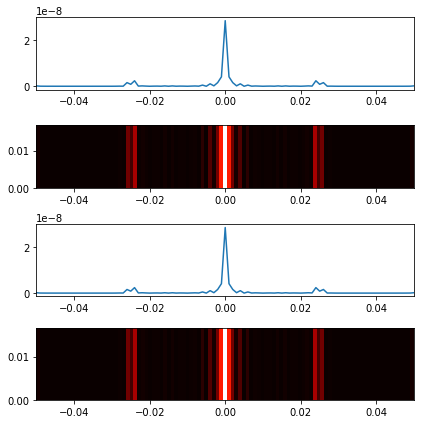

In [25]:
import math, cmath
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib import cm


def q1(a,u,beta=False):
    '''calculate kernel of diffraction grating
    
    arguments:
    a: wavenumber of grating
    u: distance along the grating
    
    optional argument:
    beta=False(default) - choose to use the second kernal function given in Newman
    
    returns:
    scalar float value
    '''
    
    if beta == True:
        beta = a/2.0
        return math.sin(a*u)**2 * math.sin(beta*u)**2
    else:
        return math.sin(a*u)**2

def integrand_q(q,u,x,K,F,ALPHA,beta=False):
    '''calculate integrand of light intensity
    
    arguments:
    q: function/kernel for optical geometry
    u: distance along the grating
    x: distance along the screen
    K: wavenumber of light = 2Pi/LAMBDA
    F: focal length of lens
    ALPHA: wavenumber for slits
    
    optional argument:
    beta=False(default) - choose to use the second kernal function given in Newman
    
    returns:
    scalar float value
    '''
    return math.sqrt(q(ALPHA,u,beta=beta))* cmath.exp(1j *K*x*u/F)

def simpsons(f,a,b,n,*args, **kwargs):
    '''
    perform an integration on a function, q(*args)
    
    arguments
    q: function to be integrated
    a: lower limit of integral
    b: upper limit of integral
    N: number of steps in integral
    
    optional argument
    *args: the function arguments for q
    
    returns:
    integrated value (scalar)
    '''
    
    h = (b-a)/N #size of step (meters)

    #initialize with low/high values of grating (a,b)
    s1 = f(q1,a,x,K,F,ALPHA) + f(q1,b,x,K,F,ALPHA)

    #add up all of the intermediate slices with simpson's odd/even weights
    for k in range(1,N):
        if i%2==0:
            s1 += 4*f(q1,a+k*h,x,K,F,ALPHA) 
        else:
            s1 += 2*f(q1,a+k*h,x,K,F,ALPHA) 
         
    s1 *= h/3
    return s1


#Constants 
SPACING = 20e-6          #slit spacing in meters, assume the machinist set this when they made the grate
    
ALPHA = math.pi/SPACING  #wavenumber for slits
W = 10*SPACING           #size of diffraction grating
LAMBDA = 500e-9          #wavelength of light - yellow/green
K = 2*math.pi/LAMBDA     #wavenumber of light
WS = 0.1                 #width of screen in meters
HS = 250                 #height in pixels
STEPS = 100              #Steps across the screen (arbitrary)
F = 1.0                  #focal length of lens in meters

screen_pattern1 = np.empty([HS,STEPS+1],float) #store intensity pattern1
screen_pattern2 = np.empty([HS,STEPS+1],float) #store intensity pattern2

#Define screen properties
a = -W/2    #lower limit of grating (meters)
b =  W/2    #upper limit of grating (meters)
N = 100     #steps of integration over grating (not screen) (unitless)
x_values=[]

#Loop over the regions on the screen
for i in range(STEPS+1):
    
    #start at the bottom of the screen (WS/2) and count up
    x = -WS/2.0 + WS*i/STEPS
    x_values.append(x)
    
    #integrate using simpson's rule - 
    #this is an oscillatory integral (no adaptive method)
    s1 = simpsons(integrand_q,a,b,N,q1,x,K,F,ALPHA)
    s2 = simpsons(integrand_q,a,b,N,q1,x,K,F,ALPHA,beta=True)

        
    #we assume a uniform grating with every y-value the same
    #so add the same value of the integral to each j value 
    #in the screen pattern
    for j in range(HS):
        screen_pattern1[j,i] = abs(s1)**2
        screen_pattern2[j,i] = abs(s2)**2

#make the density plot
fig0, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=4,figsize=(6,6))

#plot pattern 1 
ax0.plot(x_values,screen_pattern1[0])
ax1.imshow(screen_pattern1,extent=[-WS/2,WS/2,0,WS/6],cmap="hot",vmin=1e-16,vmax=1e-8)

ax0.set_xlim(x_values[0],x_values[-1])
ax2.set_xlim(x_values[0],x_values[-1])

#plot pattern2
ax2.plot(x_values,screen_pattern1[0])
ax3.imshow(screen_pattern2,extent=[-WS/2,WS/2,0,WS/6],cmap="hot",vmin=1e-16,vmax=1e-8,aspect="auto")

plt.tight_layout()
#plt.gray_r() #(vmax=,vmin=)
plt.show()
            

            


In [9]:
#I used this to determin my vmin and vmax values for the plot above
print(np.min(screen_pattern1),np.max(screen_pattern1))
print(np.min(screen_pattern2),np.max(screen_pattern2))

2.77594126526e-41 2.83473480456e-08
6.102715614e-41 1.26510073024e-08
